In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Enable inline plots for Jupyter
%matplotlib inline

# For better visuals
sns.set(style="darkgrid")


In [2]:
# Load COVID-19 dataset (e.g., WHO, Our World in Data, etc.)
df = pd.read_csv(r"all_weekly_excess_deaths.csv")  
df.head()


,country,region,region_code,start_date,end_date,days,year,week,population,total_deaths,covid_deaths,expected_deaths,excess_deaths,non_covid_deaths,covid_deaths_per_100k,excess_deaths_per_100k,excess_deaths_pct_change
0,Australia,Australia,0,2019-12-30,2020-01-05,7,2020,1,25921089,2926.0,0,2965.372893,-39.372893,2926.0,0.0,-0.151895,-0.013278
1,Australia,Australia,0,2020-01-06,2020-01-12,7,2020,2,25921089,2902.0,0,2956.539560,-54.539560,2902.0,0.0,-0.210406,-0.018447
2,Australia,Australia,0,2020-01-13,2020-01-19,7,2020,3,25921089,2914.0,0,2932.039560,-18.039560,2914.0,0.0,-0.069594,-0.006153
3,Australia,Australia,0,2020-01-20,2020-01-26,7,2020,4,25921089,3007.0,0,2940.372893,66.627107,3007.0,0.0,0.257038,0.022659
4,Australia,Australia,0,2020-01-27,2020-02-02,7,2020,5,25921089,2910.0,0,2900.039560,9.960440,2910.0,0.0,0.038426,0.003435


In [3]:
df.info() ## Check basic info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5770 entries, 0 to 5769
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   5770 non-null   object 
 1   region                    5770 non-null   object 
 2   region_code               5770 non-null   int64  
 3   start_date                5770 non-null   object 
 4   end_date                  5770 non-null   object 
 5   days                      5770 non-null   int64  
 6   year                      5770 non-null   int64  
 7   week                      5770 non-null   int64  
 8   population                5770 non-null   int64  
 9   total_deaths              5770 non-null   float64
 10  covid_deaths              5770 non-null   int64  
 11  expected_deaths           5770 non-null   float64
 12  excess_deaths             5770 non-null   float64
 13  non_covid_deaths          5770 non-null   float64
 14  covid_de

In [4]:
print(df.columns)

Index(['country', 'region', 'region_code', 'start_date', 'end_date', 'days',
       'year', 'week', 'population', 'total_deaths', 'covid_deaths',
       'expected_deaths', 'excess_deaths', 'non_covid_deaths',
       'covid_deaths_per_100k', 'excess_deaths_per_100k',
       'excess_deaths_pct_change'],
      dtype='object')


In [5]:
df.isnull().sum()# Check for missing values

country                     0
region                      0
region_code                 0
start_date                  0
end_date                    0
days                        0
year                        0
week                        0
population                  0
total_deaths                0
covid_deaths                0
expected_deaths             0
excess_deaths               0
non_covid_deaths            0
covid_deaths_per_100k       0
excess_deaths_per_100k      0
excess_deaths_pct_change    0
dtype: int64

In [6]:
print("Columns:", df.columns)
print("\nMissing values:\n", df.isnull().sum())

Columns: Index(['country', 'region', 'region_code', 'start_date', 'end_date', 'days',
       'year', 'week', 'population', 'total_deaths', 'covid_deaths',
       'expected_deaths', 'excess_deaths', 'non_covid_deaths',
       'covid_deaths_per_100k', 'excess_deaths_per_100k',
       'excess_deaths_pct_change'],
      dtype='object')

Missing values:
 country                     0
region                      0
region_code                 0
start_date                  0
end_date                    0
days                        0
year                        0
week                        0
population                  0
total_deaths                0
covid_deaths                0
expected_deaths             0
excess_deaths               0
non_covid_deaths            0
covid_deaths_per_100k       0
excess_deaths_per_100k      0
excess_deaths_pct_change    0
dtype: int64


In [7]:
!pip install pmdarima --quiet


ARIMA - (Auto Regessive integrated Moving average) can handle rising/falling patterns in deaths.Excess deaths this week likely relate to recent weeks.ARIMA can predict the next 4–12 weeks of deaths.It was built specifically to model and forecast data over time.Easy to train, doesn’t require GPUs, and gives interpretable model output.

Other Models:
 1. Prophet (by Facebook)-Slower than ARIMA
 2. SARIMA (Seasonal ARIMA)-Requires specifying seasonal parameters (P,D,Q,s) and Can be complex to tune
 3. Machine Learning Models (e.g., Random Forest, XGBoost, LSTM)-Need feature engineering + more data and Harder to interpret, slower training.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima


<Axes: title={'center': 'Excess Deaths Over Time'}, xlabel='start_date'>

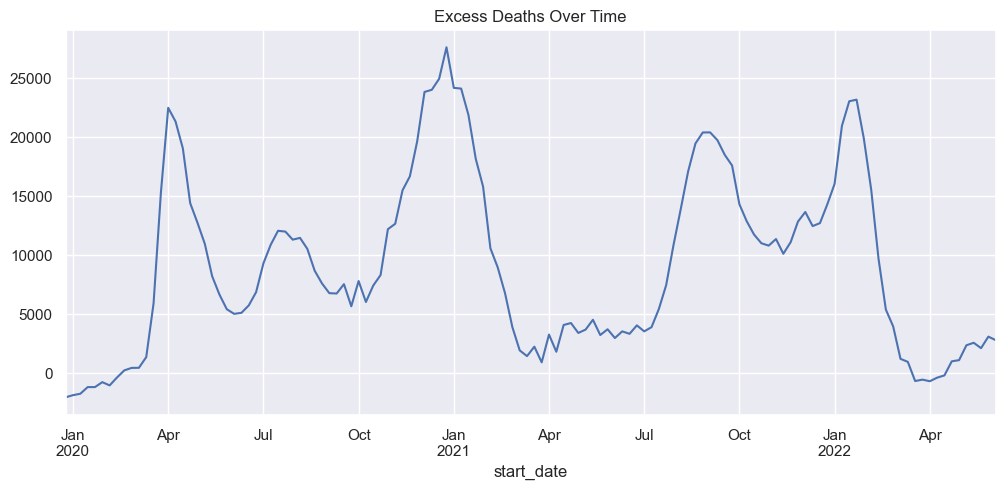

In [9]:
# Ensure date column is datetime
usa_df = df[df['country'] == 'United States'].copy()
usa_df['start_date'] = pd.to_datetime(usa_df['start_date'])

# Set index
usa_df.set_index('start_date', inplace=True)
#inplace=True means the change is applied directly to usa_df (no new object is created)

# Optionally sort just in case
usa_df = usa_df.sort_index()

# Optional: plot to check
usa_df['excess_deaths'].plot(figsize=(12,5), title='Excess Deaths Over Time')


In [10]:
usa_df.index.freq = 'W-MON' # Or 'W-SUN', 'W-SAT' depending on your data's week end

# --- Perform your train-test split ---
train_size = int(len(usa_df) * 0.8) # Example: 80% for training
train_data = usa_df['excess_deaths'].iloc[:train_size]
test_data = usa_df['excess_deaths'].iloc[train_size:]

# --- Use auto_arima to get the best order (if you haven't already) ---
# For example:
# stepwise_model = auto_arima(train_data, seasonal=False, trace=False, suppress_warnings=True)
# p, d, q = stepwise_model.order # If you already ran this, use your determined p, d, q

# --- Now train your ARIMA model ---
# Use the order you obtained (p=3, d=0, q=0 from your output)
p, d, q = 3, 0, 0 # Explicitly setting them based on your auto_arima output
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:          excess_deaths   No. Observations:                  102
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -903.606
Date:                Thu, 17 Jul 2025   AIC                           1817.211
Time:                        15:49:45   BIC                           1830.336
Sample:                    12-30-2019   HQIC                          1822.526
                         - 12-06-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9493.2842   2013.302      4.715      0.000    5547.285    1.34e+04
ar.L1          1.3568      0.079     17.169      0.000       1.202       1.512
ar.L2         -0.1798      0.145     -1.240      0.2

In [11]:
# 80/20 split
train_size = int(len(usa_df) * 0.8)
train_data = usa_df['excess_deaths'][:train_size]
test_data = usa_df['excess_deaths'][train_size:]


In [12]:
stepwise_model = auto_arima(train_data, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=1,
                            seasonal=False, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1841.637, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2206.702, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1862.030, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2088.813, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1825.702, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1826.203, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1825.100, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1824.133, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1817.445, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1822.922, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1818.804, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1819.068, Time=0.21 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 0.741 seconds
                               SARIMAX Results                                
Dep. Vari

In [13]:
# Use the order from auto_arima
p, d, q = stepwise_model.order
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:          excess_deaths   No. Observations:                  102
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -903.606
Date:                Thu, 17 Jul 2025   AIC                           1817.211
Time:                        15:49:47   BIC                           1830.336
Sample:                    12-30-2019   HQIC                          1822.526
                         - 12-06-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9493.2842   2013.302      4.715      0.000    5547.285    1.34e+04
ar.L1          1.3568      0.079     17.169      0.000       1.202       1.512
ar.L2         -0.1798      0.145     -1.240      0.2

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming train_data, test_data, and model_fit are already defined from previous steps

# Forecast same length as test data
start = len(train_data)
end = len(train_data) + len(test_data) - 1

# Rectified line: Removed typ='levels'
predictions = model_fit.predict(start=start, end=end)

# Evaluation
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

MSE: 54785791.69
RMSE: 7401.74
MAE: 6691.11


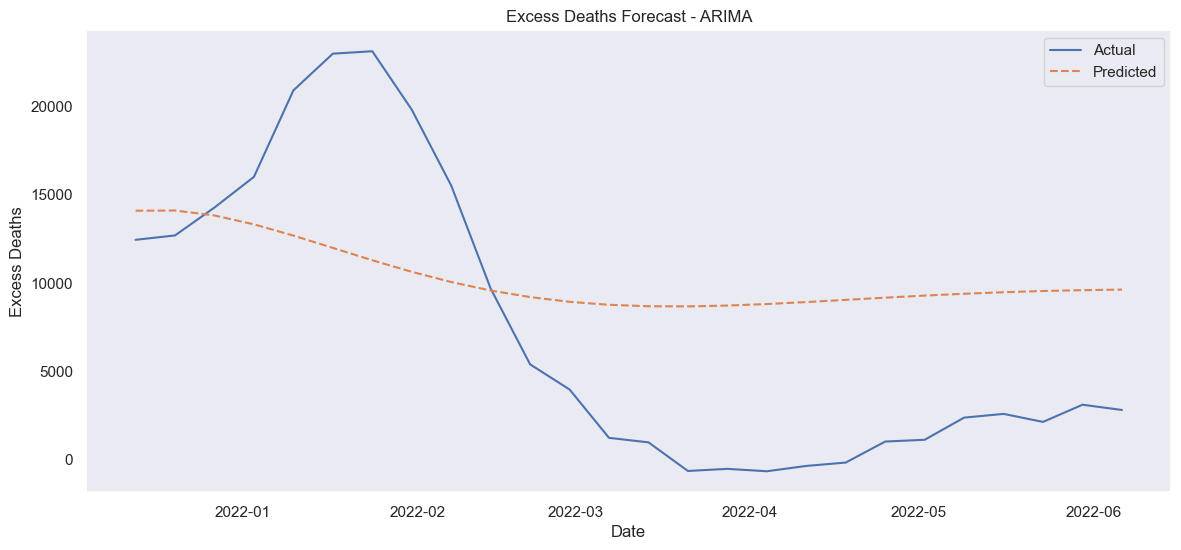

In [15]:
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, predictions, label='Predicted', linestyle='--')
plt.title('Excess Deaths Forecast - ARIMA')
plt.xlabel('Date')
plt.ylabel('Excess Deaths')
plt.legend()
plt.grid()
plt.show()


C:\Users\sidda\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


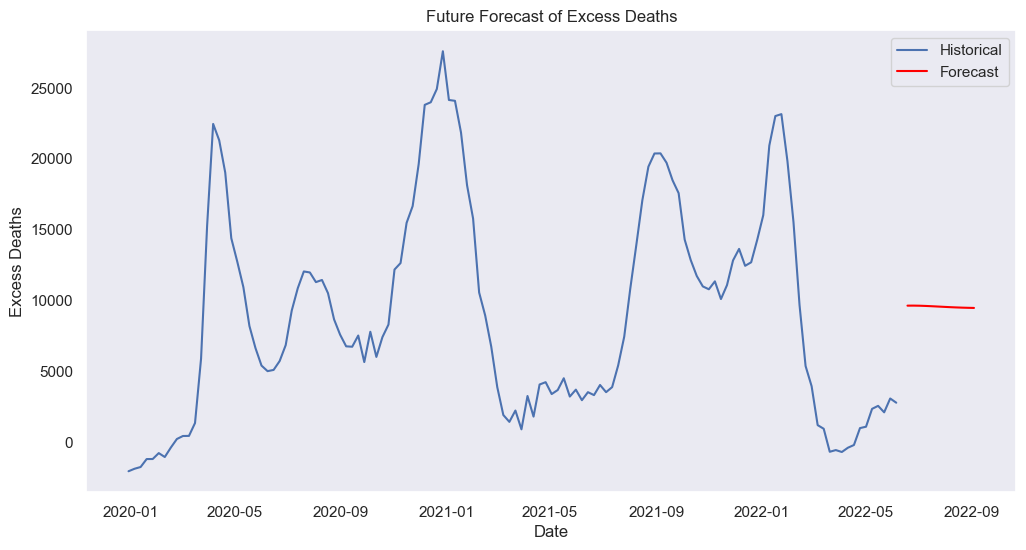

In [16]:
# Forecast 12 steps ahead (adjust as needed)
future_steps = 12
forecast = model_fit.predict(start=len(usa_df), end=len(usa_df) + future_steps - 1, typ='levels')

# Create future date range
future_dates = pd.date_range(start=usa_df.index[-1] + pd.Timedelta(days=7), periods=future_steps, freq='W')

# Plot
plt.figure(figsize=(12,6))
plt.plot(usa_df.index, usa_df['excess_deaths'], label='Historical')
plt.plot(future_dates, forecast, label='Forecast', color='red')
plt.title('Future Forecast of Excess Deaths')
plt.xlabel('Date')
plt.ylabel('Excess Deaths')
plt.legend()
plt.grid()
plt.show()


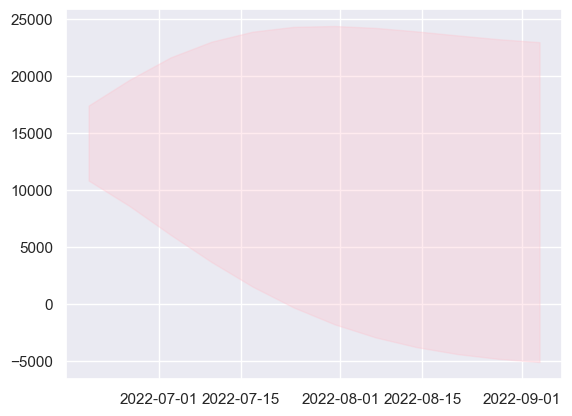

In [17]:
forecast_result = model_fit.get_forecast(steps=future_steps)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Plot
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% CI')
#Plot confidence intervals for future forecasts:

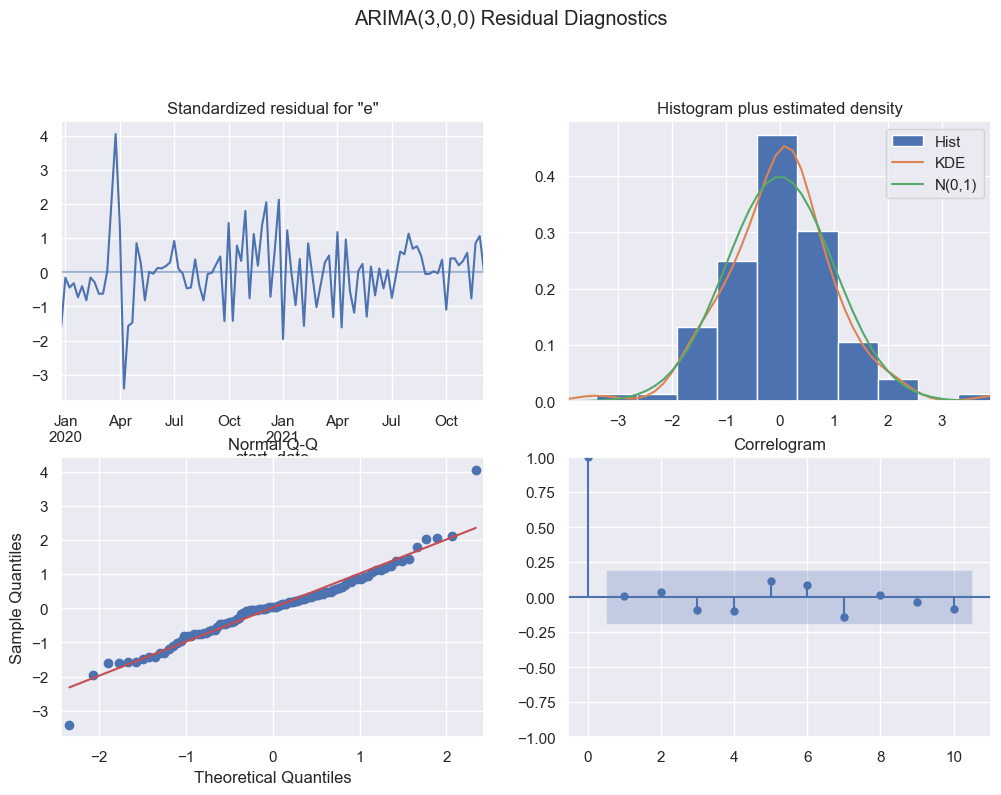

In [18]:
# Fix frequency warning by setting it explicitly
usa_df = usa_df.asfreq('W-MON')
# Residual diagnostics for the original ARIMA(3,0,0)
model_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle("ARIMA(3,0,0) Residual Diagnostics", y=1.02)
plt.show()


In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Define new model
model_2 = ARIMA(train_data, order=(2, 0, 0))
model_2_fit = model_2.fit()

# Print model summary
print(model_2_fit.summary())


                               SARIMAX Results                                
Dep. Variable:          excess_deaths   No. Observations:                  102
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -907.314
Date:                Thu, 17 Jul 2025   AIC                           1822.628
Time:                        15:49:53   BIC                           1833.128
Sample:                    12-30-2019   HQIC                          1826.880
                         - 12-06-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9493.2842   2371.290      4.003      0.000    4845.641    1.41e+04
ar.L1          1.5123      0.057     26.620      0.000       1.401       1.624
ar.L2         -0.5811      0.058    -10.016      0.0

In [20]:
# Forecast using ARIMA(2,0,0)
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions_2 = model_2_fit.predict(start=start, end=end)

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_2 = mean_squared_error(test_data, predictions_2)
rmse_2 = np.sqrt(mse_2)
mae_2 = mean_absolute_error(test_data, predictions_2)

print(f"ARIMA(2,0,0) -> RMSE: {rmse_2:.2f}, MAE: {mae_2:.2f}")


ARIMA(2,0,0) -> RMSE: 7753.70, MAE: 7039.64


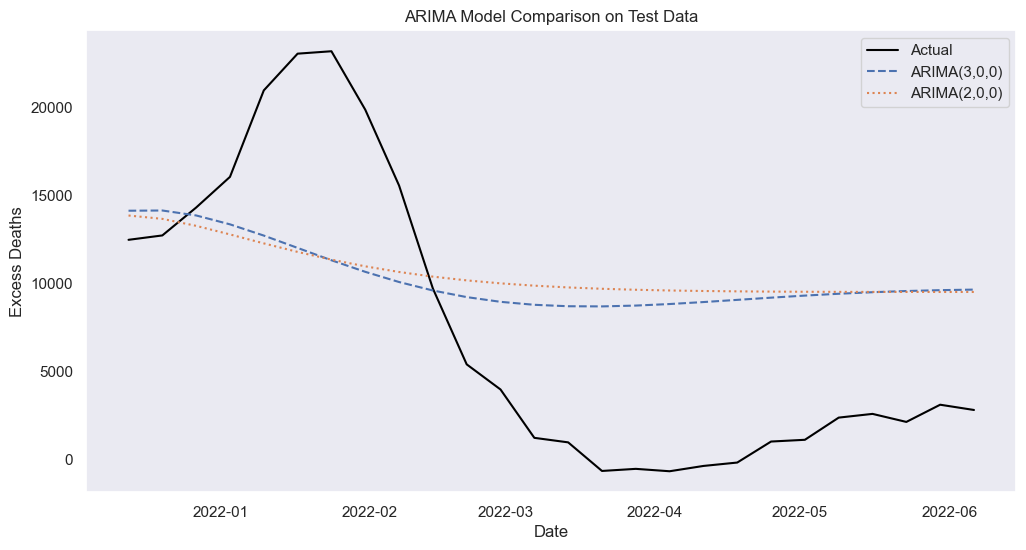

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual', color='black')
plt.plot(test_data.index, predictions, label='ARIMA(3,0,0)', linestyle='--')
plt.plot(test_data.index, predictions_2, label='ARIMA(2,0,0)', linestyle=':')
plt.title("ARIMA Model Comparison on Test Data")
plt.xlabel("Date")
plt.ylabel("Excess Deaths")
plt.legend()
plt.grid()
plt.show()


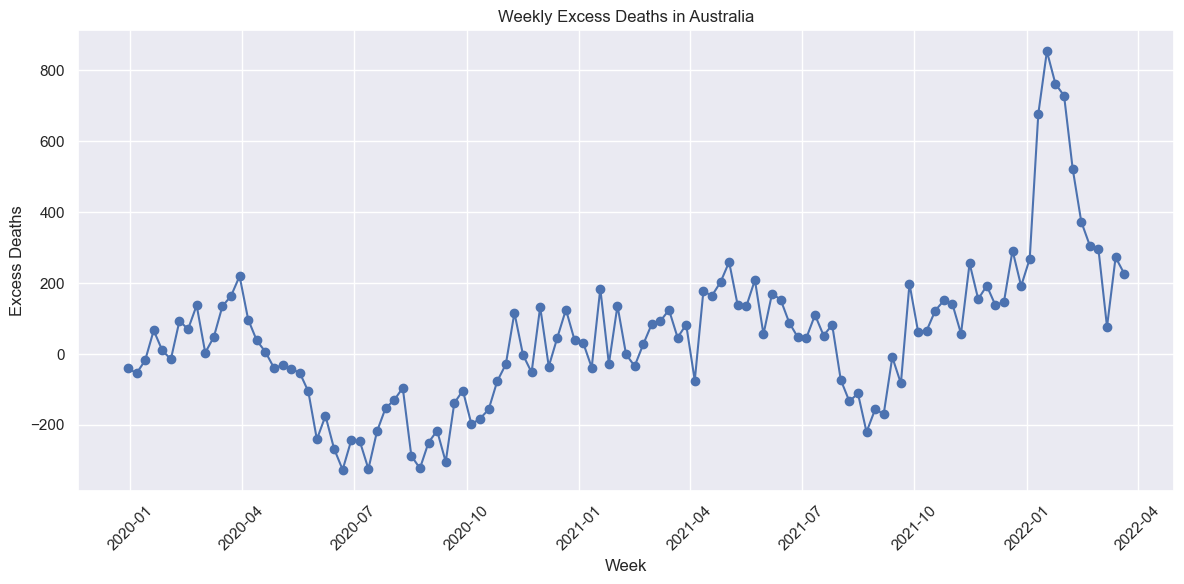

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert start_date to datetime
df['start_date'] = pd.to_datetime(df['start_date'])

# Filter for Australia
australia_df = df[df['country'] == 'Australia'].copy()

# Drop rows with missing excess deaths
australia_df = australia_df[['start_date', 'excess_deaths']].dropna()

# Sort by date
australia_df.sort_values('start_date', inplace=True)
australia_df.reset_index(drop=True, inplace=True)

# Plot the data
plt.figure(figsize=(12,6))
plt.plot(australia_df['start_date'], australia_df['excess_deaths'], marker='o')
plt.title('Weekly Excess Deaths in Australia')
plt.xlabel('Week')
plt.ylabel('Excess Deaths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


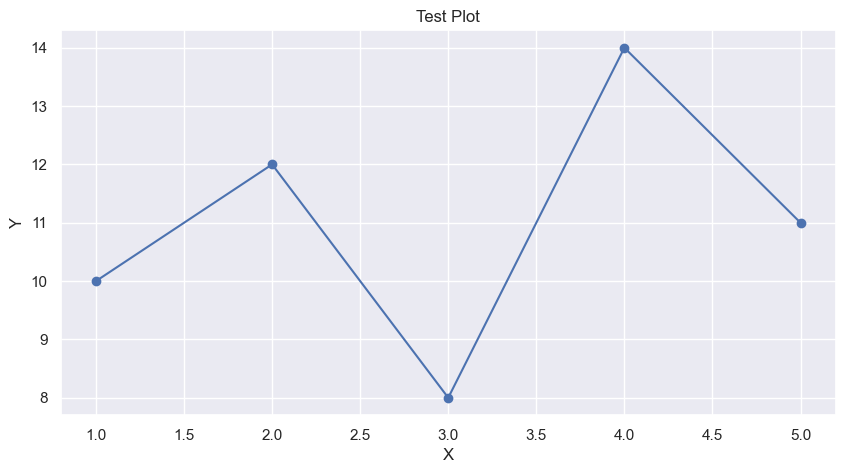

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline

x = [1, 2, 3, 4, 5]
y = [10, 12, 8, 14, 11]
# Each (x, y) pair is a point: (1,10), (2,12), (3,8), etc.
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o')
plt.title("Test Plot")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline
sns.set(style="whitegrid")


In [25]:
df = pd.read_csv("all_weekly_excess_deaths.csv")

# Convert dates
df['start_date'] = pd.to_datetime(df['start_date'])

# Show all unique country names
print(df['country'].unique())


['Australia' 'Austria' 'Belgium' 'Britain' 'Bulgaria' 'Canada' 'Chile'
 'Colombia' 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark' 'Ecuador'
 'Estonia' 'Finland' 'France' 'Germany' 'Greece' 'Guatemala' 'Hungary'
 'Iceland' 'Iran' 'Israel' 'Italy' 'Latvia' 'Lithuania' 'Luxembourg'
 'Malta' 'Mexico' 'Montenegro' 'Netherlands' 'New Zealand' 'Norway' 'Peru'
 'Poland' 'Portugal' 'Romania' 'Slovakia' 'Slovenia' 'South Africa'
 'South Korea' 'Spain' 'Sweden' 'Switzerland' 'Tunisia' 'United States']


In [26]:
# Load dataset
df = pd.read_csv("all_weekly_excess_deaths.csv")

# Convert start_date column to datetime
df['start_date'] = pd.to_datetime(df['start_date'])

# Filter for United States
usa_df = df[df['country'] == 'United States'].copy()

# Drop missing values for target column
usa_df = usa_df[['start_date', 'excess_deaths']].dropna()

# Sort by date
usa_df.sort_values('start_date', inplace=True)
usa_df.reset_index(drop=True, inplace=True)

# Check first few rows
usa_df.head()


,start_date,excess_deaths
0,2019-12-30,-2051.057203
1,2020-01-06,-1874.057203
2,2020-01-13,-1751.723870
3,2020-01-20,-1189.890537
4,2020-01-27,-1187.723870


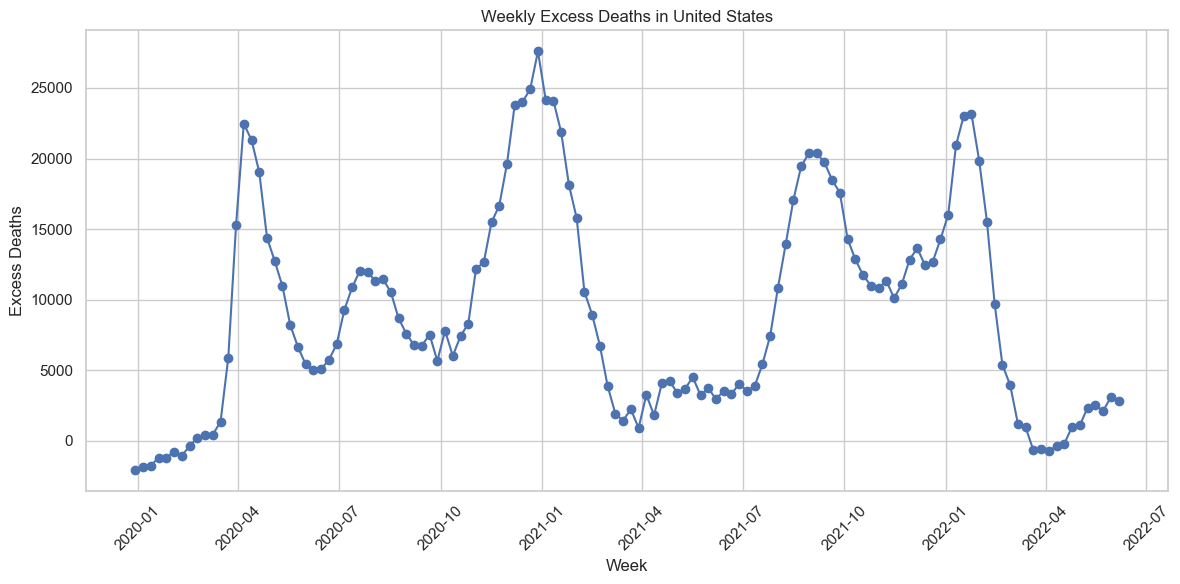

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(usa_df['start_date'], usa_df['excess_deaths'], marker='o')
plt.title('Weekly Excess Deaths in United States')
plt.xlabel('Week')
plt.ylabel('Excess Deaths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
## Percentage increase = (observed - expected) / expected * 100.

In [29]:
# Convert start_date to numeric for regression
usa_df['date_ordinal'] = usa_df['start_date'].apply(lambda x: x.toordinal())

# Features and target
X = usa_df[['date_ordinal']]
y = usa_df['excess_deaths']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R² Score: -0.7236311811315854
RMSE: 10562.318900625465


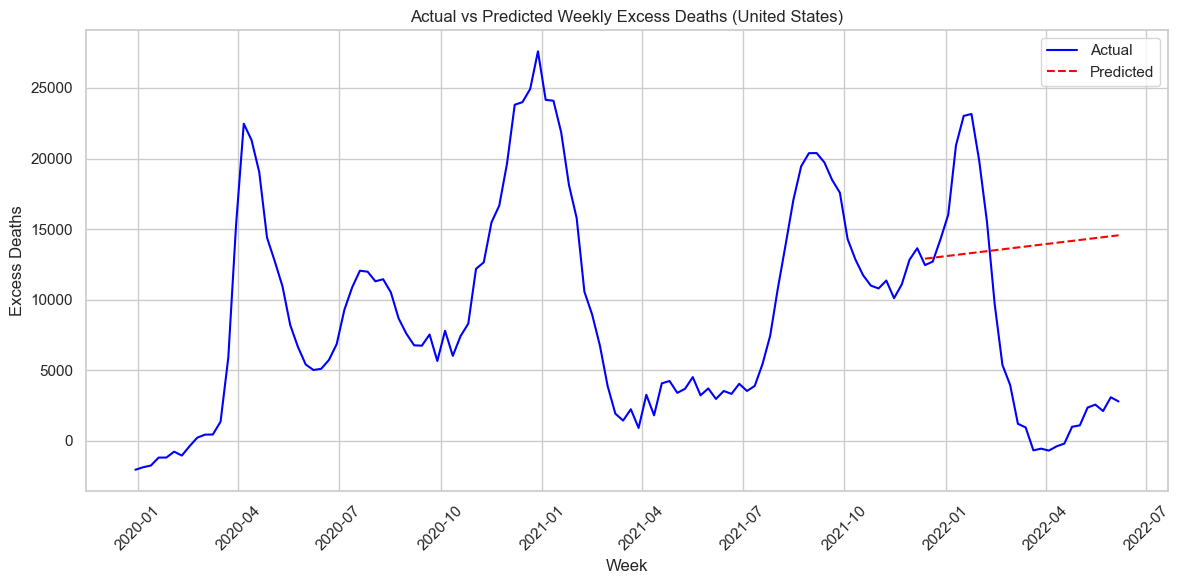

In [30]:
plt.figure(figsize=(12,6))
plt.plot(usa_df['start_date'], usa_df['excess_deaths'], label='Actual', color='blue')
plt.plot(usa_df.iloc[len(X_train):]['start_date'], y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Weekly Excess Deaths (United States)')
plt.xlabel('Week')
plt.ylabel('Excess Deaths')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [31]:
# Future prediction for next 4 weeks
last_date = usa_df['start_date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=4, freq='W')
future_ordinals = np.array([d.toordinal() for d in future_dates]).reshape(-1, 1)
future_preds = model.predict(future_ordinals)

# Display predictions
for date, pred in zip(future_dates, future_preds):
    print(f"Week: {date.date()} → Predicted Excess Deaths: {int(pred)}")


Week: 2022-06-19 → Predicted Excess Deaths: 14683
Week: 2022-06-26 → Predicted Excess Deaths: 14750
Week: 2022-07-03 → Predicted Excess Deaths: 14816
Week: 2022-07-10 → Predicted Excess Deaths: 14882


C:\Users\sidda\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Week: 2022-06-19 → Predicted Excess Deaths: 14683
Week: 2022-06-26 → Predicted Excess Deaths: 14750
Week: 2022-07-03 → Predicted Excess Deaths: 14816
Week: 2022-07-10 → Predicted Excess Deaths: 14882


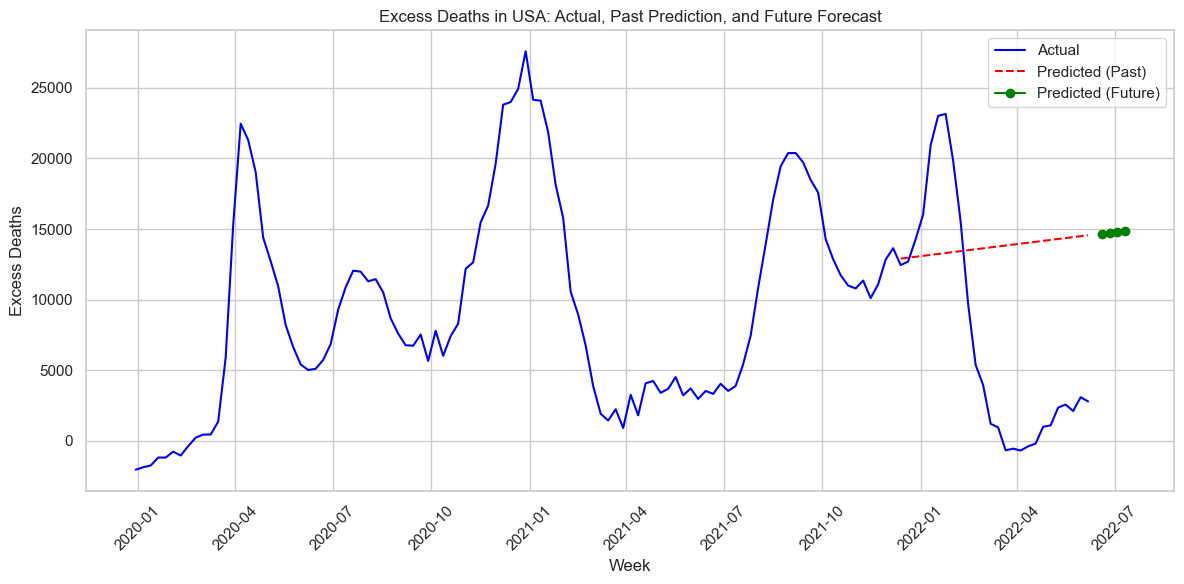

In [32]:
# Future prediction for next 4 weeks
last_date = usa_df['start_date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=4, freq='W')
future_ordinals = np.array([d.toordinal() for d in future_dates]).reshape(-1, 1)

# Convert to DataFrame to match training feature names
future_df = pd.DataFrame(future_ordinals, columns=['date_ordinal'])

# Predict
future_preds = model.predict(future_df)

# Print predictions
for date, pred in zip(future_dates, future_preds):
    print(f"Week: {date.date()} → Predicted Excess Deaths: {int(pred)}")

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(usa_df['start_date'], usa_df['excess_deaths'], label='Actual', color='blue')
plt.plot(usa_df.iloc[len(X_train):]['start_date'], y_pred, label='Predicted (Past)', color='red', linestyle='--')
plt.plot(future_dates, future_preds, label='Predicted (Future)', color='green', marker='o')
plt.title('Excess Deaths in USA: Actual, Past Prediction, and Future Forecast')
plt.xlabel('Week')
plt.ylabel('Excess Deaths')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#Visualization

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
# Load COVID-19 dataset (e.g., WHO, Our World in Data, etc.)
df = pd.read_csv(r"all_weekly_excess_deaths.csv")  
df.head()


,country,region,region_code,start_date,end_date,days,year,week,population,total_deaths,covid_deaths,expected_deaths,excess_deaths,non_covid_deaths,covid_deaths_per_100k,excess_deaths_per_100k,excess_deaths_pct_change
0,Australia,Australia,0,2019-12-30,2020-01-05,7,2020,1,25921089,2926.0,0,2965.372893,-39.372893,2926.0,0.0,-0.151895,-0.013278
1,Australia,Australia,0,2020-01-06,2020-01-12,7,2020,2,25921089,2902.0,0,2956.539560,-54.539560,2902.0,0.0,-0.210406,-0.018447
2,Australia,Australia,0,2020-01-13,2020-01-19,7,2020,3,25921089,2914.0,0,2932.039560,-18.039560,2914.0,0.0,-0.069594,-0.006153
3,Australia,Australia,0,2020-01-20,2020-01-26,7,2020,4,25921089,3007.0,0,2940.372893,66.627107,3007.0,0.0,0.257038,0.022659
4,Australia,Australia,0,2020-01-27,2020-02-02,7,2020,5,25921089,2910.0,0,2900.039560,9.960440,2910.0,0.0,0.038426,0.003435


In [38]:
df.tail()

,country,region,region_code,start_date,end_date,days,year,week,population,total_deaths,covid_deaths,expected_deaths,excess_deaths,non_covid_deaths,covid_deaths_per_100k,excess_deaths_per_100k,excess_deaths_pct_change
5765,United States,United States,0,2022-05-09,2022-05-15,7,2022,19,336997624,57864.0,1868,55510.914407,2353.085593,55996.0,0.554307,0.698250,0.042390
5766,United States,United States,0,2022-05-16,2022-05-22,7,2022,20,336997624,57523.0,2461,54958.314407,2564.685593,55062.0,0.730272,0.761040,0.046666
5767,United States,United States,0,2022-05-23,2022-05-29,7,2022,21,336997624,56959.0,2607,54850.514407,2108.485593,54352.0,0.773596,0.625668,0.038441
5768,United States,United States,0,2022-05-30,2022-06-05,7,2022,22,336997624,57545.0,1956,54459.714407,3085.285593,55589.0,0.580420,0.915521,0.056653
5769,United States,United States,0,2022-06-06,2022-06-12,7,2022,23,336997624,57710.0,2770,54923.314407,2786.685593,54940.0,0.821964,0.826916,0.050738


In [39]:
df.describe()

,region_code,days,year,week,population,total_deaths,covid_deaths,expected_deaths,excess_deaths,non_covid_deaths,covid_deaths_per_100k,excess_deaths_per_100k,excess_deaths_pct_change
count,5770.0,5770.0,5770.000000,5770.000000,5.770000e+03,5770.000000,5770.000000,5770.000000,5770.000000,5770.000000,5770.000000,5770.000000,5770.000000
mean,0.0,7.0,2020.750433,24.220624,3.120102e+07,5697.674385,586.102426,4925.623684,772.050700,5111.571958,1.779043,2.341445,0.142107
std,0.0,0.0,0.730038,15.089277,5.401340e+07,10510.772931,1653.624735,8940.263278,2334.268651,9220.806975,2.629101,4.210041,0.255349
min,0.0,7.0,2020.000000,1.000000,3.703350e+05,28.000000,0.000000,36.958708,-3884.712360,28.000000,0.000000,-8.776743,-0.390527
25%,0.0,7.0,2020.000000,11.000000,5.403021e+06,953.250000,7.000000,867.375983,-0.516362,882.000000,0.112374,-0.009925,-0.000743
50%,0.0,7.0,2021.000000,22.000000,1.046710e+07,2203.850000,71.000000,1978.483427,100.641011,2042.500000,0.719079,1.144515,0.071504
75%,0.0,7.0,2021.000000,37.000000,3.830773e+07,6433.250000,405.750000,5687.962381,553.124692,5840.750000,2.339688,3.192287,0.193627
max,0.0,7.0,2022.000000,53.000000,3.369976e+08,87417.000000,23386.000000,64029.902966,28233.523876,70577.000000,19.562486,38.801037,3.782780


In [40]:
df.isnull().sum() #Sum of values which are null

country                     0
region                      0
region_code                 0
start_date                  0
end_date                    0
days                        0
year                        0
week                        0
population                  0
total_deaths                0
covid_deaths                0
expected_deaths             0
excess_deaths               0
non_covid_deaths            0
covid_deaths_per_100k       0
excess_deaths_per_100k      0
excess_deaths_pct_change    0
dtype: int64

In [41]:
df.columns

Index(['country', 'region', 'region_code', 'start_date', 'end_date', 'days',
       'year', 'week', 'population', 'total_deaths', 'covid_deaths',
       'expected_deaths', 'excess_deaths', 'non_covid_deaths',
       'covid_deaths_per_100k', 'excess_deaths_per_100k',
       'excess_deaths_pct_change'],
      dtype='object')

In [42]:
df.drop(df.index[101:5771], inplace=True)
df

,country,region,region_code,start_date,end_date,days,year,week,population,total_deaths,covid_deaths,expected_deaths,excess_deaths,non_covid_deaths,covid_deaths_per_100k,excess_deaths_per_100k,excess_deaths_pct_change
0,Australia,Australia,0,2019-12-30,2020-01-05,7,2020,1,25921089,2926.0,0,2965.372893,-39.372893,2926.0,0.000000,-0.151895,-0.013278
1,Australia,Australia,0,2020-01-06,2020-01-12,7,2020,2,25921089,2902.0,0,2956.539560,-54.539560,2902.0,0.000000,-0.210406,-0.018447
2,Australia,Australia,0,2020-01-13,2020-01-19,7,2020,3,25921089,2914.0,0,2932.039560,-18.039560,2914.0,0.000000,-0.069594,-0.006153
3,Australia,Australia,0,2020-01-20,2020-01-26,7,2020,4,25921089,3007.0,0,2940.372893,66.627107,3007.0,0.000000,0.257038,0.022659
4,Australia,Australia,0,2020-01-27,2020-02-02,7,2020,5,25921089,2910.0,0,2900.039560,9.960440,2910.0,0.000000,0.038426,0.003435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Australia,Australia,0,2021-11-01,2021-11-07,7,2021,44,25921089,3285.0,84,3144.196629,140.803371,3201.0,0.324060,0.543200,0.044782
97,Australia,Australia,0,2021-11-08,2021-11-14,7,2021,45,25921089,3152.0,61,3094.596629,57.403371,3091.0,0.235330,0.221454,0.018550
98,Australia,Australia,0,2021-11-15,2021-11-21,7,2021,46,25921089,3303.0,60,3047.196629,255.803371,3243.0,0.231472,0.986854,0.083947
99,Australia,Australia,0,2021-11-22,2021-11-28,7,2021,47,25921089,3232.0,49,3076.996629,155.003371,3183.0,0.189035,0.597982,0.050375


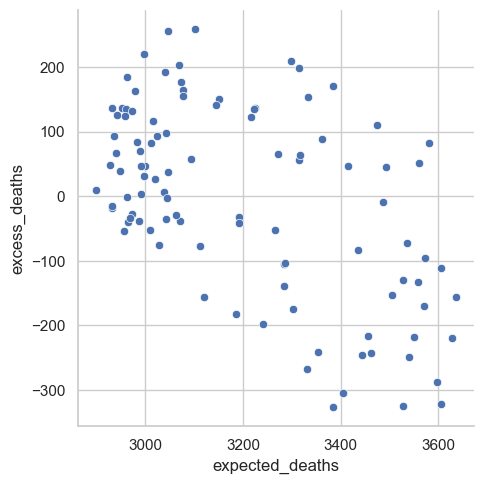

In [45]:
sns.relplot(x="expected_deaths", y="excess_deaths", data=df)

# Display the plot
plt.show()

In [46]:
df.columns.tolist()

['country',
 'region',
 'region_code',
 'start_date',
 'end_date',
 'days',
 'year',
 'week',
 'population',
 'total_deaths',
 'covid_deaths',
 'expected_deaths',
 'excess_deaths',
 'non_covid_deaths',
 'covid_deaths_per_100k',
 'excess_deaths_per_100k',
 'excess_deaths_pct_change']

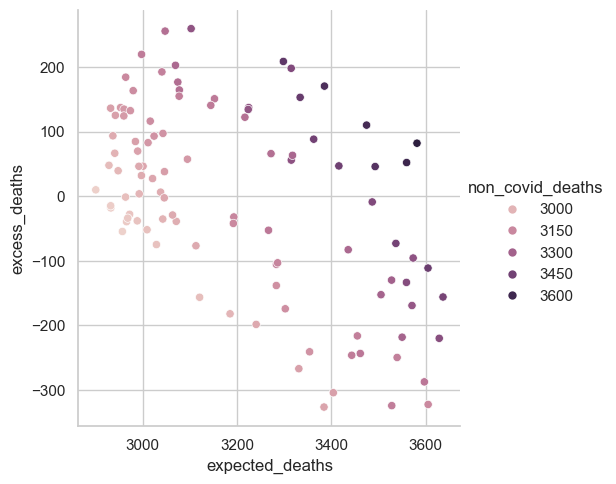

In [48]:
sns.relplot(x="expected_deaths", y="excess_deaths", hue="non_covid_deaths", data=df)
##hue hepls us to plot all those data into the specific colors plot

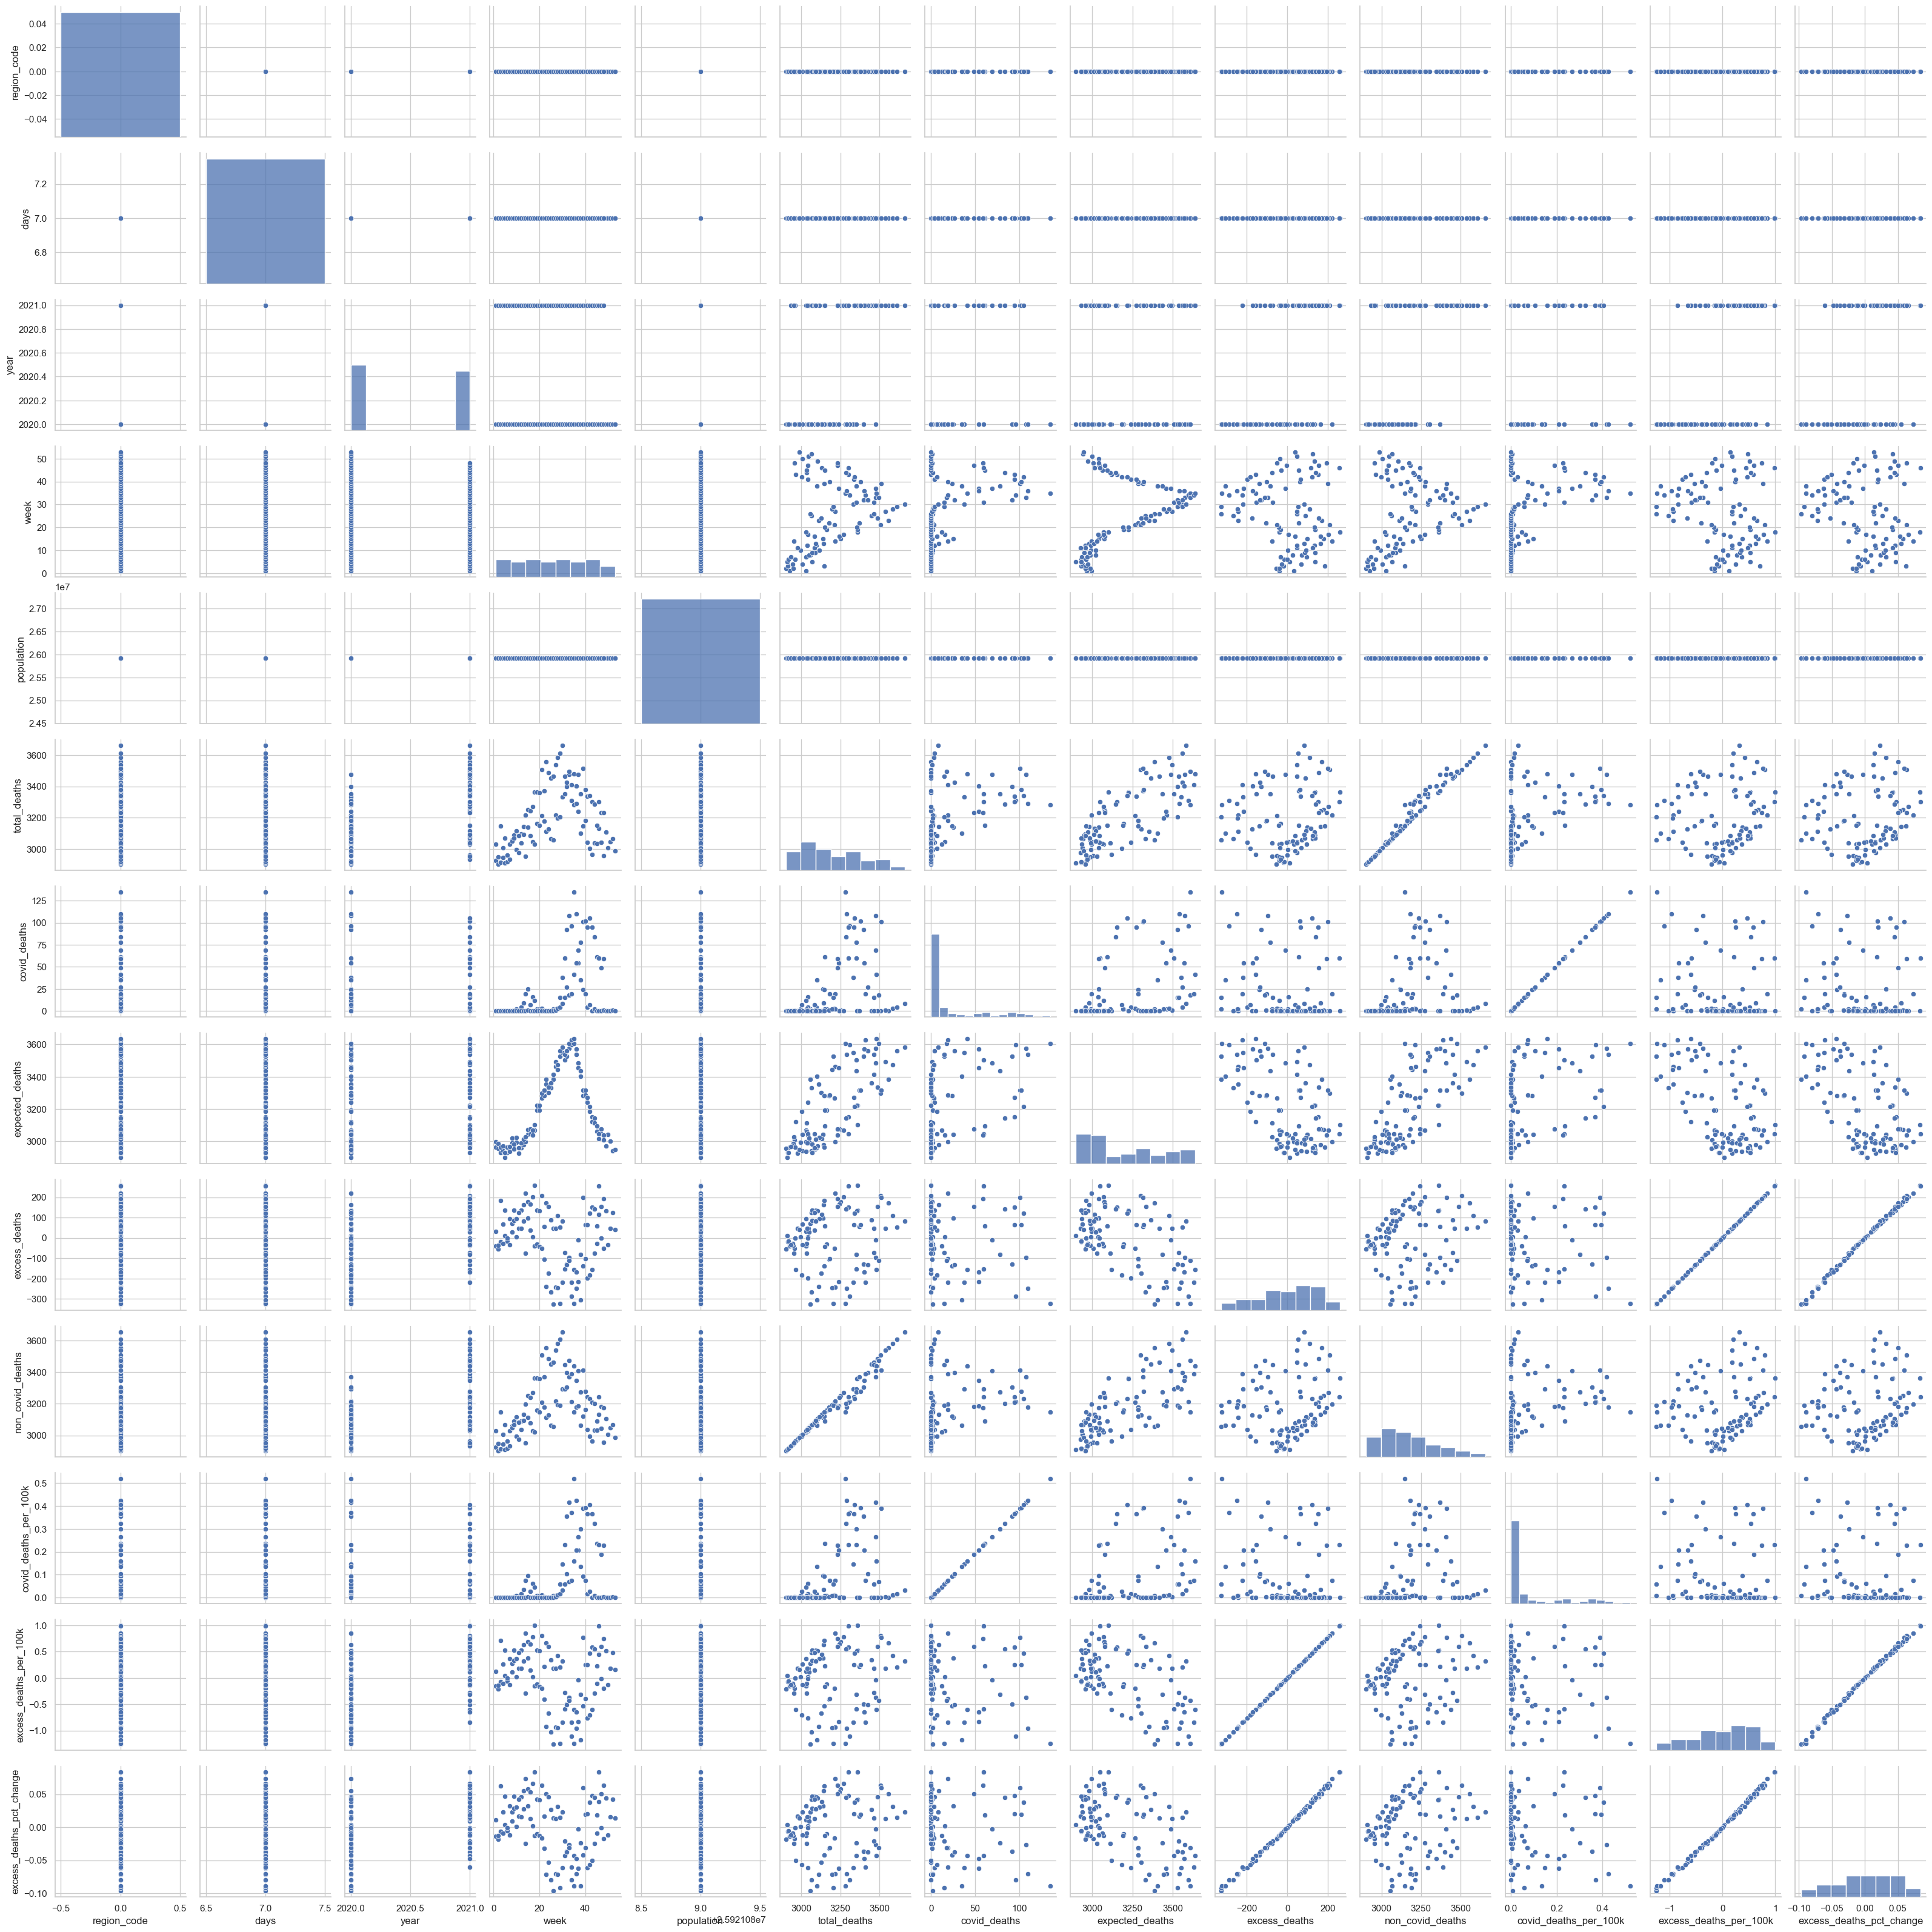

In [51]:
sns.pairplot(df) ## the whole pic of the dataset where related to eachother

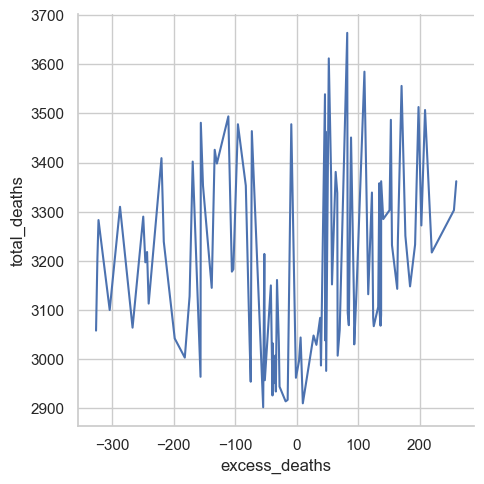

In [52]:
sns.relplot(x="excess_deaths",y="total_deaths",kind='line',data=df)

In [53]:
df.columns

Index(['country', 'region', 'region_code', 'start_date', 'end_date', 'days',
       'year', 'week', 'population', 'total_deaths', 'covid_deaths',
       'expected_deaths', 'excess_deaths', 'non_covid_deaths',
       'covid_deaths_per_100k', 'excess_deaths_per_100k',
       'excess_deaths_pct_change'],
      dtype='object')

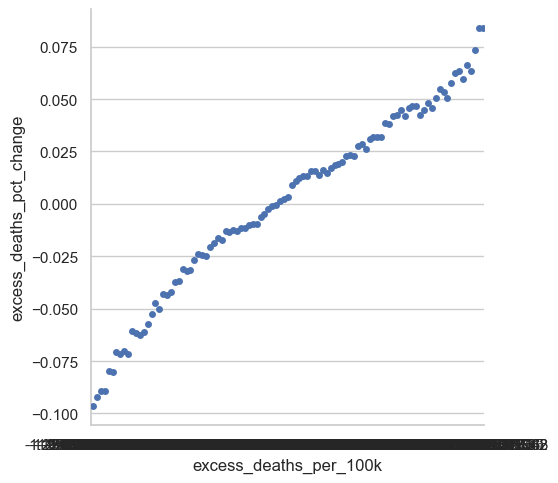

In [54]:
sns.catplot(x="excess_deaths_per_100k",y="excess_deaths_pct_change",data=df)